In [16]:
from mpl_toolkits.basemap import Basemap
from shapely.geometry import Point, MultiPoint
import pandas as pd
import matplotlib.pyplot as plt
import mplleaflet
import matplotlib.cm as cm
import matplotlib.colors as co
import numpy as np
import random
import networkx as nx
from scipy import sparse
import scipy.sparse.linalg

#1 North America 2 Central America 3 South America
#4 East Asia 5 Southeast Asia 6 South Asia 7 Central Asia 12 Oceania
#8 Western Europe 9 Eastern Europe
#10 Middle East 11 Sub-saharian Africa

dataframe = pd.read_csv('Features pre-processed.csv', 
                            usecols=["eventid", "country", "region", "longitude", "latitude", "iyear", "nkill", "gname",
                                     "success", "suicide", "attacktype1_txt", "targtype1", "targtype1_txt", "natlty1", "weaptype1", "related"]);
dataframe.columns;

N_edges:  411
N_nodes:  185


<Figure size 432x288 with 0 Axes>

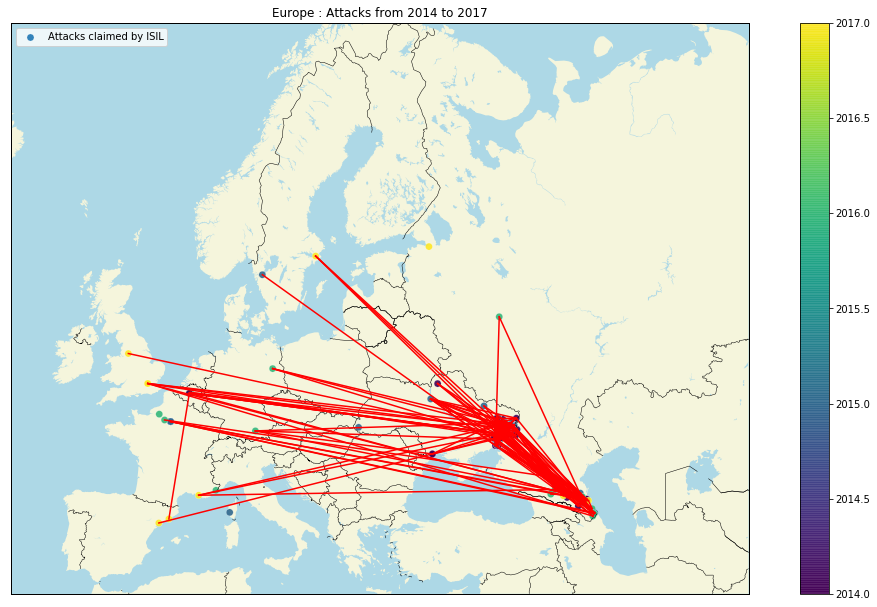

In [17]:
europe = Basemap(
        projection='merc',
        ellps = 'WGS84',
        llcrnrlon=-15, 
        llcrnrlat=35,
        urcrnrlon=65,
        urcrnrlat=70,
        lat_ts=0,
        resolution='i',
        suppress_ticks=True)

europe_dataframe = dataframe.loc[dataframe['region'] >= 8 ] #europe
europe_dataframe = europe_dataframe.loc[europe_dataframe['region'] <= 9 ]
europe_dataframe = europe_dataframe.loc[europe_dataframe['longitude'] < 65]

europe_isil = europe_dataframe.loc[europe_dataframe['nkill'] >= 3]
#europe_isil = europe_dataframe.loc[europe_dataframe["gname"] == "Islamic State of Iraq and the Levant (ISIL)"]
europe_isil.reset_index(inplace = True)

europe_isil_points = pd.Series(
                [Point(europe(mapped_x, mapped_y))
                 for mapped_x, mapped_y in zip(europe_isil['longitude'], 
                                               europe_isil['latitude'])])

n_nodes = europe_isil['latitude'].size
adj_isil = np.zeros((n_nodes, n_nodes))

lons = europe_isil['longitude'].values
lats = europe_isil['latitude'].values

weapon_isil  = europe_isil['weaptype1'].values


x, y = europe(lons, lats)

plt.clf()
fig = plt.figure()
ax = fig.add_subplot(111, facecolor='w', frame_on=False)
fig.set_size_inches(18.5, 10.5)

year_isil = europe_isil["iyear"]

dev = europe.scatter(
            [geom.x for geom in europe_isil_points],
            [geom.y for geom in europe_isil_points],
            50, marker='o', lw=.25,
            c=year_isil, edgecolor='w', label='Attacks claimed by ISIL',
            alpha=0.9,antialiased=True,
            zorder=2)

plt.colorbar()

# To determine if two nodes are connected, we compute a threshold by looking at their similarities with respect to specific 
# features, thus allowing to compute the probability for an edge to be generated

n_edges = 0

for index, rows in europe_isil.iterrows():
    for index2, rows2 in europe_isil.iterrows():
        if (index2 > index):
            threshold = 0
            if (rows['targtype1_txt'] == rows2['targtype1_txt']):
                threshold = threshold + 0.0375
                #threshold = threshold + 0.25
            if (rows['gname'] == rows2['gname']):
                threshold = threshold + 0.03215
                #threshold = threshold + 0.2
            if (rows['attacktype1_txt'] == rows2['attacktype1_txt']):
                threshold = threshold + 0.01875
                #threshold = threshold + 0.15
            if (rows['natlty1'] == rows2['natlty1']):
                #threshold = threshold + 0.0125
                threshold = threshold
            if (rows['suicide'] == rows2['suicide']):
                #threshold = threshold + 0.0125
                threshold = threshold
            if (rows['weaptype1'] == rows2['weaptype1']):
                threshold = threshold + 0.00625
                #threshold = threshold + 0.05
            if (rows['country'] == rows2['country']):
                #threshold = threshold + 0.00625
                threshold = threshold

            r = random.randint(1, 101) / 100
            if (r <= threshold and adj_isil[index, index2] == 0):
                n_edges = n_edges + 1
                adj_isil[index, index2] = 1
                adj_isil[index2, index] = 1
                lons = [rows['longitude'], rows2['longitude']]
                lats = [rows['latitude'], rows2['latitude']]
                x, y = europe(lons, lats)
                europe.plot(x, y, marker=None,color='r')

print("N_edges: ", n_edges)
print("N_nodes: ", n_nodes)


europe.fillcontinents(color='beige',lake_color='lightblue');
europe.drawcountries();
europe.drawmapboundary(fill_color='lightblue');
plt.title('Europe : Attacks from 2014 to 2017')
plt.legend()

Average degree:  4.443243243243243


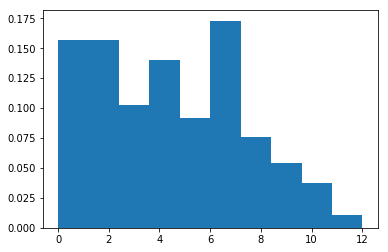

In [18]:
#plt.spy(adj_isil)

degrees =  sum(adj_isil)
weights = np.ones_like(degrees) / float(n_nodes)
plt.hist(degrees, weights=weights);

# Average degree

avg_deg = sum(degrees) / n_nodes
print("Average degree: ", avg_deg)

disconnected_index = np.where(degrees == 0)

In [19]:
# In order to analyze the network, we first get rid of disconnected components, i.e those whose degree is equal to 0

degree_matrix = np.diag(degrees)
degree_column = pd.Series([degree
                 for degree in degrees])

if 'degree' not in europe_isil:
    europe_isil.insert(1, "degree", degree_column)
    
europe_isil = europe_isil.loc[europe_isil['degree'] != 0]
europe_isil_points = pd.Series(
                [Point(europe(mapped_x, mapped_y))
                 for mapped_x, mapped_y in zip(europe_isil['longitude'], 
                                               europe_isil['latitude'])])

if (adj_isil.shape[0] == n_nodes):
    adj_isil = np.delete(adj_isil, disconnected_index, axis=1)
    adj_isil = np.delete(adj_isil, disconnected_index, axis=0)
    
if (degree_matrix.shape[0] == n_nodes):
    degree_matrix = np.delete(degree_matrix, disconnected_index, axis=1)
    degree_matrix = np.delete(degree_matrix, disconnected_index, axis=0)

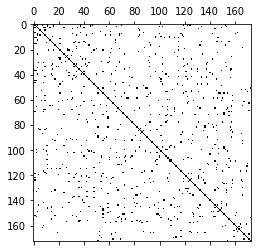

In [20]:
# Computation of the normalized Laplacian
laplacian_combinatorial = sparse.csr_matrix(degree_matrix - adj_isil) 
inv_sqrt_degree_matrix = np.diag(1 / np.diag(degree_matrix**(0.5)))

laplacian_normalized = inv_sqrt_degree_matrix @ laplacian_combinatorial @ inv_sqrt_degree_matrix
plt.spy(laplacian_normalized)

laplacian = laplacian_normalized

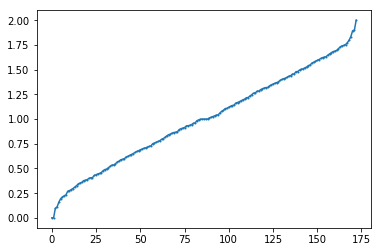

In [21]:
# Laplacian eigendecomposition

eigenvalues, eigenvectors = scipy.linalg.eigh(laplacian)

assert eigenvectors.shape == adj_isil.shape

plt.plot(np.real(eigenvalues), '.-', markersize=2);

**We notice an important gap between the second and the third eigenvalue: it could thus be interesting to see if we could cluster our remaining nodes by using three clusters in the k-means algorithm

<Figure size 432x288 with 0 Axes>

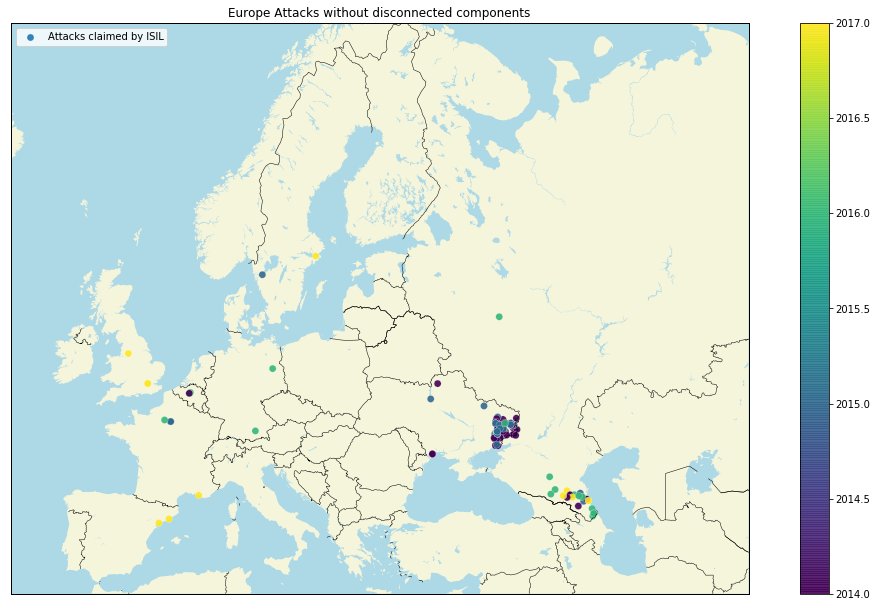

In [22]:
europe = Basemap(
        projection='merc',
        ellps = 'WGS84',
        llcrnrlon=-15, 
        llcrnrlat=35,
        urcrnrlon=65,
        urcrnrlat=70,
        lat_ts=0,
        resolution='i',
        suppress_ticks=True)

year_isil = europe_isil["iyear"]

plt.clf()
fig = plt.figure()
ax = fig.add_subplot(111, facecolor='w', frame_on=False)
fig.set_size_inches(18.5, 10.5)

dev = europe.scatter(
            [geom.x for geom in europe_isil_points],
            [geom.y for geom in europe_isil_points],
            50, marker='o', lw=.25,
            c=year_isil, edgecolor='w', label='Attacks claimed by ISIL',
            alpha=0.9,antialiased=True,
            zorder=2)

plt.colorbar()

europe.fillcontinents(color='beige',lake_color='lightblue');
europe.drawcountries();
europe.drawmapboundary(fill_color='lightblue');
plt.title('Europe Attacks without disconnected components')
plt.legend()

/Users/aminmekacher/miniconda3/envs/ntds_project/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


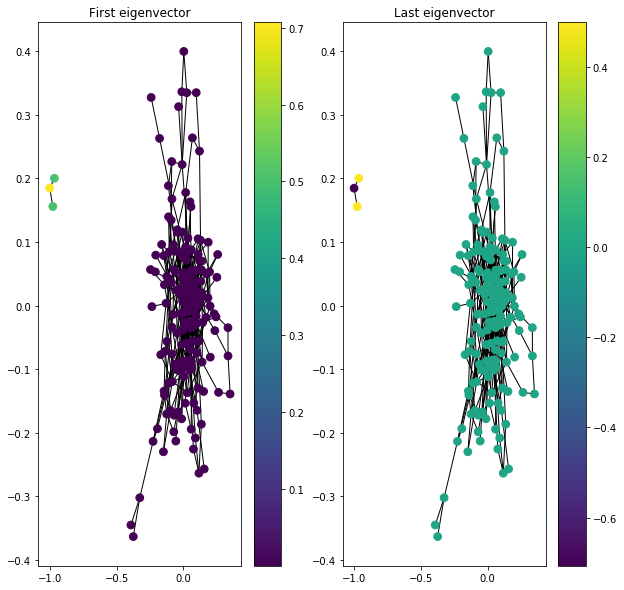

In [23]:
# Plotting the first and last eigenvectors as signals
last_eigen = adj_isil.shape[0] - 1
fig, ax = plt.subplots(1, 2, figsize=(10,10))
fig.subplots_adjust(hspace=.25)
fig.subplots_adjust(wspace=.2)

graph = nx.from_scipy_sparse_matrix(scipy.sparse.csr_matrix(adj_isil))
coords = nx.spring_layout(graph)

u0_plot = nx.draw_networkx_nodes(graph, coords, node_size=60, node_color=eigenvectors[:, 0], ax=ax[0])
nx.draw_networkx_edges(graph, coords, edge_color='k', ax=ax[0] )
ax[0].set_title('First eigenvector')
plt.colorbar(u0_plot,ax=ax[0])

u850_plot = nx.draw_networkx_nodes(graph, coords, node_size=60, node_color=eigenvectors[:, last_eigen], ax=ax[1])
nx.draw_networkx_edges(graph, coords, edge_color='k')
ax[1].set_title('Last eigenvector')
plt.colorbar(u850_plot,ax=ax[1])

plt.show()

/Users/aminmekacher/miniconda3/envs/ntds_project/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


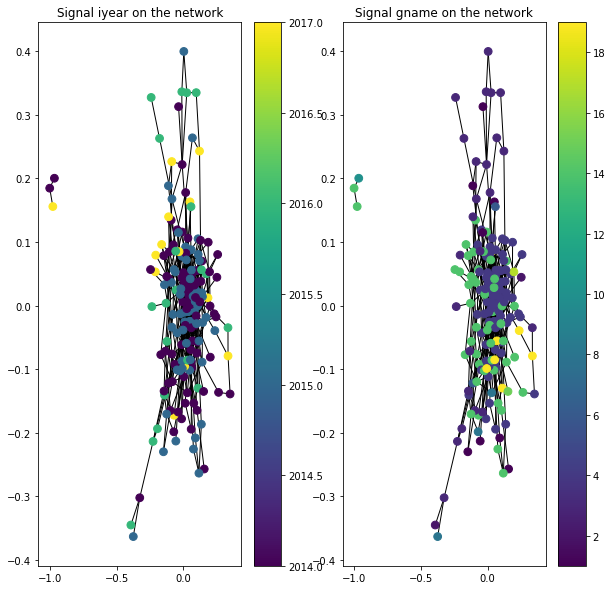

In [24]:
year_europe  = europe_isil['iyear'].values
#gname_europe = europe_isil['gname'].values
#gname_europe = gname_europe == 'Islamic State of Iraq and the Levant (ISIL)'
gname_europe = europe_isil['targtype1']

fig, ax = plt.subplots(1, 2, figsize=(10,10))
fig.subplots_adjust(hspace=.25)
fig.subplots_adjust(wspace=.2)

year_plot = nx.draw_networkx_nodes(graph, coords, node_size=60, node_color=year_europe, ax=ax[0])
nx.draw_networkx_edges(graph, coords, edge_color='k', ax=ax[0])
ax[0].set_title('Signal iyear on the network')
plt.colorbar(year_plot,ax=ax[0])

gname_plot = nx.draw_networkx_nodes(graph, coords, node_size=60, node_color=gname_europe, ax=ax[1])
nx.draw_networkx_edges(graph, coords, edge_color='k', ax=ax[1])
ax[1].set_title('Signal gname on the network')
plt.colorbar(gname_plot,ax=ax[1])
